<a href="https://colab.research.google.com/github/uday-routhu/week5/blob/master/Classification_Metrics_Core.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Metrics (Core)

- author: Udayakumar Routhu

# Tasks

1) Check for class balance with value_counts

2) Prepare a column transformer for preprocessing​

3) Build and fit a model pipeline with the preprocessor and a default decisiontreeclassifer (use a random_state of 42)

4) Evaluate the classification model using the custom function to produce the confusion matrix and classification report.

In a text cell, answer the following

What was the overall accuracy of the model? (Considering the accuracy and class balance, how would you describe the default model's performance?)
Using this model, what percentage of the predictions would cause an unnecessary stroke alert for a patient that did not end up having a stroke? (A false positive)?
Using this model, what percentage of the predictions would miss warning a patient who ended up having a stroke (False Negatives)
Considering this dataset is used to identify stokes which metric do you think would be important to optimize? Why?

```

### Import Libraries

In [56]:
# Pandas
import pandas as pd
# Numpy
import numpy as np
# MatplotLib
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer

# Models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer

# Classification Metrics
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay


# Set global scikit-learn configuration
from sklearn import set_config
# Display estimators as a diagram
set_config(display='diagram') # 'text' or 'diagram'}

In [57]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Load the dataset

In [58]:
# Load in the dataset from url
fpath = "/content/drive/MyDrive/CodingDojo/02-MachineLearning/Week06/Data/stroke.csv"
df = pd.read_csv(fpath, index_col=0)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
1192,Female,31,0,0,No,Govt_job,Rural,70.66,27.2,never smoked,0
77,Female,13,0,0,No,children,Rural,85.81,18.6,Unknown,0
59200,Male,18,0,0,No,Private,Urban,60.56,33.0,never smoked,0
24905,Female,65,0,0,Yes,Private,Urban,205.77,46.0,formerly smoked,1
24257,Male,4,0,0,No,children,Rural,90.42,16.2,Unknown,0


In [59]:
# Display the number of rows and columns for the dataframe
df.shape
print(f'There are {df.shape[0]} rows, and {df.shape[1]} columns.')
print(f'The rows represent {df.shape[0]} observations, and the columns represent {df.shape[1]-1} features and 1 target variable.')

There are 1137 rows, and 11 columns.
The rows represent 1137 observations, and the columns represent 10 features and 1 target variable.


# Prepare the Data

## Clean the Data**

In [60]:
# Display the info for the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1137 entries, 1192 to 5731
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1137 non-null   object 
 1   age                1137 non-null   object 
 2   hypertension       1137 non-null   int64  
 3   heart_disease      1137 non-null   int64  
 4   ever_married       1137 non-null   object 
 5   work_type          1137 non-null   object 
 6   Residence_type     1137 non-null   object 
 7   avg_glucose_level  1137 non-null   float64
 8   bmi                1085 non-null   float64
 9   smoking_status     1137 non-null   object 
 10  stroke             1137 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 106.6+ KB


**Which columns should be converted to a numeric dtype?**
   - **Your Answer:**
      - age

In [61]:
# Clean 'age' column by converting non-numeric values to NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Convert 'age' column to integers, NaN will remain as float type
df['age'] = df['age'].astype('Int64')

# Confirm the datatype
df['age'].dtype

Int64Dtype()

In [62]:
# Check summary statistics
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,1136.0,1137.000000,1137.000000,1137.000000,1085.000000,1137.000000
mean,45.15669,0.118734,0.068602,107.664002,29.198065,0.120493
std,23.054467,0.323617,0.252887,47.618723,7.669615,0.325680
min,0.0,0.000000,0.000000,55.270000,11.300000,0.000000
25%,28.0,0.000000,0.000000,77.600000,24.100000,0.000000
50%,48.0,0.000000,0.000000,91.820000,28.500000,0.000000
75%,63.0,0.000000,0.000000,113.850000,33.200000,0.000000
max,82.0,1.000000,1.000000,266.590000,64.400000,1.000000


- No errors noted.

In [63]:
df['age'].value_counts()

79    26
57    24
78    24
52    23
55    22
      ..
46     7
6      7
22     7
12     6
4      6
Name: age, Length: 83, dtype: Int64

In [64]:
df.duplicated().sum()

0

* there are no duplicated records

In [65]:
df.isna().sum()

gender                0
age                   1
hypertension          0
heart_disease         0
ever_married          0
work_type             0
Residence_type        0
avg_glucose_level     0
bmi                  52
smoking_status        0
stroke                0
dtype: int64

- **Never use fillna() to impute values prior to Train_Test_Split, as it would cause data leakage.**

In [66]:
data_types = df.dtypes
str_cols = data_types[data_types=='object'].index
for col in str_cols:
    print(f'- {col}:')
    print(df[col].value_counts(dropna=False))
    print("\n\n")
    print(df[col])

- gender:
Female    642
Male      494
Other       1
Name: gender, dtype: int64



id
1192     Female
77       Female
59200      Male
24905    Female
24257      Male
          ...  
18205    Female
13622      Male
59749      Male
12109    Female
5731     Female
Name: gender, Length: 1137, dtype: object
- ever_married:
Yes    769
No     368
Name: ever_married, dtype: int64



id
1192      No
77        No
59200     No
24905    Yes
24257     No
        ... 
18205     No
13622     No
59749    Yes
12109    Yes
5731     Yes
Name: ever_married, Length: 1137, dtype: object
- work_type:
Private          672
Self-employed    174
children         147
Govt_job         142
Never_worked       2
Name: work_type, dtype: int64



id
1192     Govt_job
77       children
59200     Private
24905     Private
24257    children
           ...   
18205    children
13622    children
59749     Private
12109     Private
5731      Private
Name: work_type, Length: 1137, dtype: object
- Residence_type:
Urban    587
R

* There are no inconsistent categories

In [67]:
# Check data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1137 entries, 1192 to 5731
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             1137 non-null   object 
 1   age                1136 non-null   Int64  
 2   hypertension       1137 non-null   int64  
 3   heart_disease      1137 non-null   int64  
 4   ever_married       1137 non-null   object 
 5   work_type          1137 non-null   object 
 6   Residence_type     1137 non-null   object 
 7   avg_glucose_level  1137 non-null   float64
 8   bmi                1085 non-null   float64
 9   smoking_status     1137 non-null   object 
 10  stroke             1137 non-null   int64  
dtypes: Int64(1), float64(2), int64(3), object(5)
memory usage: 107.7+ KB


In [68]:
# Obtain summary statistics
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,1136.0,1137.000000,1137.000000,1137.000000,1085.000000,1137.000000
mean,45.15669,0.118734,0.068602,107.664002,29.198065,0.120493
std,23.054467,0.323617,0.252887,47.618723,7.669615,0.325680
min,0.0,0.000000,0.000000,55.270000,11.300000,0.000000
25%,28.0,0.000000,0.000000,77.600000,24.100000,0.000000
50%,48.0,0.000000,0.000000,91.820000,28.500000,0.000000
75%,63.0,0.000000,0.000000,113.850000,33.200000,0.000000
max,82.0,1.000000,1.000000,266.590000,64.400000,1.000000


### **Check Class Balance**

In [69]:
df['gender'].value_counts(normalize = False)

Female    642
Male      494
Other       1
Name: gender, dtype: int64

In [70]:
# Check how many samples of each class are present
df['gender'].value_counts(normalize=True)

Female    0.564644
Male      0.434477
Other     0.000880
Name: gender, dtype: float64

In [71]:

## Drop unwanted/inappropriate columns
bad_cols = ['ever_married','work_type','Residence_type']
df = df.drop(columns=bad_cols)
df.head()

,gender,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,
1192,Female,31,0,0,70.66,27.2,never smoked,0
77,Female,13,0,0,85.81,18.6,Unknown,0
59200,Male,18,0,0,60.56,33.0,never smoked,0
24905,Female,65,0,0,205.77,46.0,formerly smoked,1
24257,Male,4,0,0,90.42,16.2,Unknown,0


### **Split the Data**

In [89]:
# Define X and y
target = 'stroke'
X = df.drop(columns = [target]).copy()
y = df[target]

In [90]:
# train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


#### Class Balance

In [91]:
# Check how many samples of each class are present for train
y_train.value_counts(normalize=True)

0    0.879108
1    0.120892
Name: stroke, dtype: float64

### **Transformers**

In [92]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
print("OneHotEncoder Columns:", ohe_cols)
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "Missing")
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline(impute_na, ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
# Numerical Preprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)
# instantiate preprocessors
impute_median = SimpleImputer(strategy='median')
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline(impute_median, scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)
# Create the Column Transformer
preprocessor = ColumnTransformer([num_tuple, ohe_tuple],
                                 verbose_feature_names_out=False)

OneHotEncoder Columns: Index(['gender', 'smoking_status'], dtype='object')
Numeric Columns: Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')


In [93]:
# Create an instance of the model
dtc = DecisionTreeClassifier(random_state=42)
# Create a model pipeline
clf_pipe = make_pipeline(preprocessor, dtc)
# Fit the model
clf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi'], dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='Missing',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['gender', 'smoking_status'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(random_state=42))])

### **KNN Model**

In [77]:
# Create an instance of the model
#knn = KNeighborsClassifier()
# Create the model pipeline with a scaler
scaler = StandardScaler()
# Create a model pipeline
#knn_pipe = make_pipeline(preprocessor, knn)
clf_pipe = make_pipeline(scaler,)
# Fit the model
#knn_pipe.fit(X_train, y_train)
clf_pipe.fit(X_train, y_train)

ValueError: ignored

In [94]:
clf_pipe.predict(X_train)

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [95]:
y_train

id
23427    0
68171    0
50536    0
35999    0
47427    0
        ..
71143    0
39769    0
70447    0
63864    0
11632    0
Name: stroke, Length: 852, dtype: int64

### **Model Evaluation**

#### Evaluation Functions

In [96]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict

def evaluate_classification(model, X_train, y_train, X_test, y_test,
                            figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                         output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                         label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                        output_dict=True,figsize=figsize,
                                        colorbar=colorbar, cmap=cmap_test,
                                        label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       749
           1       1.00      1.00      1.00       103

    accuracy                           1.00       852
   macro avg       1.00      1.00      1.00       852
weighted avg       1.00      1.00      1.00       852



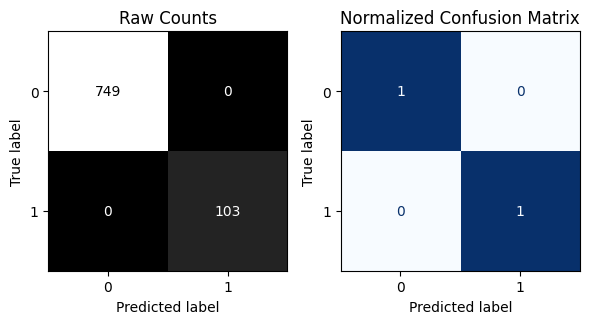


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       251
           1       0.22      0.21      0.21        34

    accuracy                           0.82       285
   macro avg       0.56      0.55      0.55       285
weighted avg       0.81      0.82      0.82       285



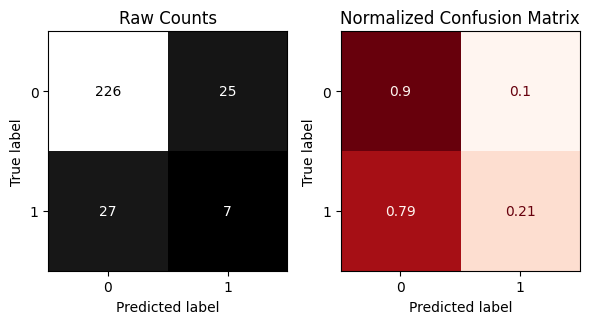

In [97]:
## Evaluate the model
evaluate_classification(clf_pipe, X_train, y_train, X_test, y_test)

1. What was the overall accuracy of the model? (Considering the accuracy and class balance, how would you describe the default model's performance?)
   * The overall accuracy of the model is 82% on the test data and a perfect 100% on the training data.
   * Considering the class balance and the high accuracy, the default model's performance appears to be quite good on the training data. It achieves perfect accuracy on the training data, indicating that it correctly predicted all instances in the training set.

2. Using this model, what percentage of the predictions would cause an unnecessary stroke alert for a patient that did not end up having a stroke? (A false positive)?
   * Percentage of False Positives = 100% - Precision for class 1
   * Percentage of False Positives = 100% - 22%
   * Percentage of False Positives = 78%
   * pproximately 78% of the predictions made by the model that are classified as class 1 would cause an unnecessary stroke alert for patients who did not actually have a stroke (false positives).

3. Using this model, what percentage of the predictions would miss warning a patient who ended up having a stroke (False Negatives)
  * Percentage of False Negatives = 100% - Recall for class 1
  * Percentage of False Negatives = 100% - 21%
  * Percentage of False Negatives = 79%
  * approximately 79% of patients who actually had a stroke would not be correctly warned by the model (false negatives).

4. Considering this dataset is used to identify stokes which metric do you think would be important to optimize? Why?
  * Precision and F1-Score are important considerations.
  * In the context of identifying strokes, the metric that would be particularly important to optimize is Recall.
  * It will minimize the number of false negatives, ensuring that as many true positive cases are correctly identified and alerted.
  * This helps prioritize patient safety by reducing the risk of missing critical cases that require immediate medical attention.